In [311]:
%load_ext autoreload
%autoreload

import sys
sys.path.append('../')

import warnings
warnings.filterwarnings('ignore')

import os
from   io     import StringIO
import numpy  as np
import pandas as pd
import csv

import iris
import matplotlib.pyplot as plt
import numpy.ma as ma
%matplotlib inline
import cartopy.crs as ccrs
from   libs.plot_maps    import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Input information

Just needs to say where all the data is stored and fill out a netcdf or pp file for input.

In [312]:
dir = '../data/driving_data/'

files = {'bareground': 'bareground2000-2014.nc',
         'alphaMax'  : 'alpha_12monthMax2000-2014.nc',
         'alpha'     : 'alpha2000-2014.nc',
         'emc'       : 'emc2000-2014.nc',
         'treeCover' : 'treecover2000-2014.nc',
         'lightning' : 'lightning_ignitions2000-2014.nc',
         'pasture'   : 'pasture2000-2014.nc',
         'popDen'    : 'population_density2000-2014.nc',
         'cropland'  : 'cropland2000-2014.nc'}

param_file= '../outputs/params-test.csv'

Open data. The model takes data in the same dict class as above.

In [313]:
##open data
input_data = {}
for key, file in files.items():
    data = iris.load_cube(dir + file)
    input_data[key] = data
    
    

params = pd.read_csv(param_file)

In the standard set of data, we have bareghround % and not vegetative fraction. So this needs converting. If you have vegCover already calculated, then add to the files above and don't run the box below

In [314]:
input_data["vegCover"] = input_data["bareground"].copy()
input_data["vegCover"].data = (100 - input_data["vegCover"].data) / 100

Plotting annual averages just to make sure the data looks senible

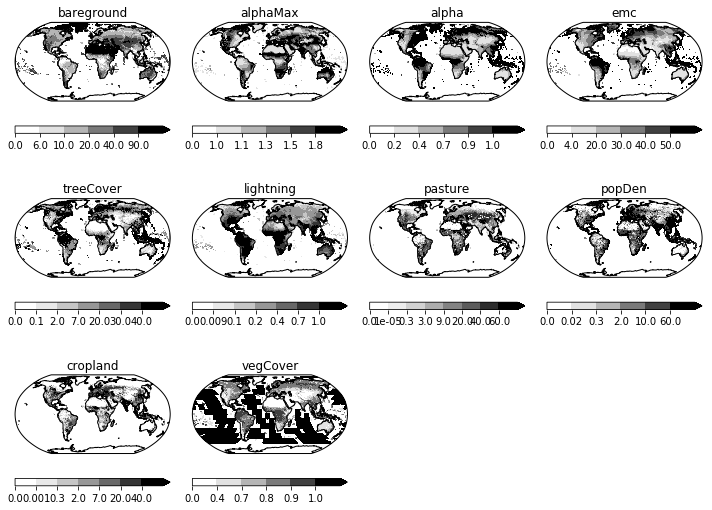

In [315]:
nd = 0

plt.figure(figsize = (10, 7.5))

for key, dat in input_data.items():
    nd = nd + 1
    dat = dat.collapsed('z', iris.analysis.MEAN)
    dat.long_name = key
    plot_lonely_cube(dat, 3, 4, nd, cmap = 'Greys', levels = None)
    #lt.show()
    

## The model
The model is now defined. See documentation paper in NCC for full model equations. This could bem moved into a library at some point, but I've defined it here so you can have a proper look.

The model calculates a number of things needed to predict burnt area, and a few metric (potential limitation and sensitivity) on the fly. The things needed to calculate burnt area are ``ConFIRE.``:

* **Controls**:
    * ``fuel``: fuel continuity
    * ``moisture``: fuel mositure content 
    * ``ignitions``: potential ignitions
    * ``suppression``: human fire suppression and landscape fragmentation
    
* **Limitation from controls**, the maximum allowed fire considering limitation from:
    * ``standard_fuel``:  fuel 
    * ``standard_moisture``:  moisture
    * ``standard_ignitions``:  ignitions
    * ``standard_suppression``:  suppression
    
* and ``burnt_area``: burnt area from all limitations

Things calculated on the fly are:

* **Potential limitation**, the increase in burnt area if limitation where removed from:
    * ``potential_fuel``:  fuel 
    * ``potential_moisture``:  moisture
    * ``potential_ignitions``:  ignitions
    * ``potential_suppression``:  suppression

* **Sensitvity**, the rate of change in burnt area for a given control, relative to the maximum possible rate of change for that controls:
    * ``sensitivity_fuel``:  fuel 
    * ``sensitivity_moisture``:  moisture
    * ``sensitivity_ignitions``:  ignitions
    * ``sensitivity_suppression``:  suppression

In [316]:
class ConFIRE(object):
    def __init__(self, data, params):        
        self.params = params
        
        self.fuel = self.control_fuel(data['vegCover'], data['alphaMax'], self.params['fuel_pw'],
                                      self.params['fuel_pg'])
        
        self.moisture = self.control_moisture(data['alpha'], data['emc'], data['treeCover'],
                                              self.params['cM'], self.params['cMT'])
        
        self.ignitions = self.control_ignitions(data['lightning'], data['pasture'], data['popDen'],
                                              self.params['cP'], self.params['cD1'])
        
        self.suppression = self.control_suppression(data['cropland'], data['popDen'],
                                              self.params['cD2'])
        
        self.standard_fuel        = self.sigmoid(self.fuel       ,
                                            self.params[       'fuel_x0'], self.params[       'fuel_k'])
        self.standard_moisture    = self.sigmoid(self.moisture   ,
                                            self.params[   'moisture_x0'], -self.params[   'moisture_k'])
        self.standard_ignitions   = self.sigmoid(self.ignitions   ,
                                            self.params[  'igntions_x0'], self.params[  'igntions_k'])
        self.standard_suppression = self.sigmoid(self.suppression,
                                            self.params['suppression_x0'], -self.params['suppression_k'])
        
        self.burnt_area = self.params['max_f'] * self.standard_fuel * self.standard_moisture * \
                          self.standard_ignitions * self.standard_suppression
    
    def control_fuel(self, cover, alphaMax, fp, fpg):
        """
        Definition to describe fuel load: while return the input; capability to be modified later.
        """
        
        return (cover**fp) * (fpg * (alphaMax-1) + 1) / (1 + fpg)

    
    def control_moisture(self, alpha, emc, treeCover, cM, cMT):
        """
        Definition to describe moisture
        """
        return (alpha + 0.01*cM*emc + 0.01*cMT * treeCover) / (1 + cM + cMT)

    
    def control_ignitions(self, lightning, pasture, popDen, cP, cD1):
        """
        Definition for the measure of ignition
        """
        ignite = lightning + cP*pasture + cD1*popDen

        return ignite

    
    def control_suppression(self, cropland, popDen, cD2):
        """
        Definition for the measure of fire supression
        """
        return cropland + cD2*popDen
    
    
    def potential_fuel(self):
        return self.potential(self.standard_fuel)
    
    
    def potential_moisture(self):
        return self.potential(self.standard_moisture)
    
    
    def potential_ignitions(self):
        return self.potential(self.standard_ignitions)
    
    
    def potential_suppression(self):
        return self.potential(self.standard_suppression)
    
    
    def sensitivity_fuel(self):
        return self.sensitivity(self.fuel, self.params['fuel_x0'], self.params['fuel_k'],
                                self.standard_fuel)
    
    
    def sensitivity_moisture(self):
        return self.sensitivity(self.moisture, self.params['moisture_x0'], -self.params['moisture_k'], 
                                self.standard_moisture)
    
    
    def sensitivity_ignitions(self):
        return self.sensitivity(self.ignitions, self.params['igntions_x0'], self.params['igntions_k'], 
                                self.standard_ignitions)
    
    
    def sensitivity_suppression(self):
        return self.sensitivity(self.suppression, self.params['suppression_x0'], -self.params['suppression_k'] , 
                                self.standard_suppression)
    
          
    def sensitivity(self, x, x0, k, fi):  
        
        gradient = self.gradient(x, x0, k)        
        return gradient * self.control_removal(fi)
    
    
    def control_removal(self, fi):
        return self.burnt_area/fi
    
    
    def potential(self, fi):
        fi.data = self.burnt_area.data * ((1/fi.data) - 1)
        return fi
    
    
    def gradient(self, x, x0, k, dx = 0.0001):

        f1 = self.sigmoid(x + dx, x0, k)
        f2 = self.sigmoid(x - dx, x0, k)
                
        n1 = self.sigmoid(x0 + dx, x0, k)
        n2 = self.sigmoid(x0 - dx, x0, k)
        
        return (f1 - f2)/(n1 - n2)
    
    
    def sigmoid(self, x, x0,k):
        """
        Sigmoid function to describe limitation using tensor
        """
        
        x = -k*(x - x0)
        try:
            x.data = 1.0/(1.0 + np.exp(x.data))
        except:
            x = 1.0/(1.0 + np.exp(x))
        return x

## Check that everything is working okay
Here, we run the model with the median of each parameter and plot each of the outputs mentioned abpver to make sure everything is happy

In [317]:
model = ConFIRE(input_data, params.median())

### Plotting
#### Burnt area

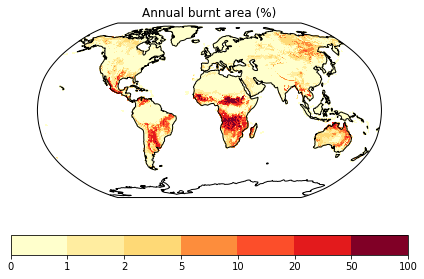

In [318]:
burnt_area = model.burnt_area.collapsed('z', iris.analysis.MEAN)
burnt_area.long_name = "Annual burnt area (%)"
burnt_area.data = burnt_area.data * 1200
plot_lonely_cube(burnt_area, levels = [0, 1, 2, 5, 10, 20, 50, 100], cmap = "brewer_YlOrRd_09")

#### Controls

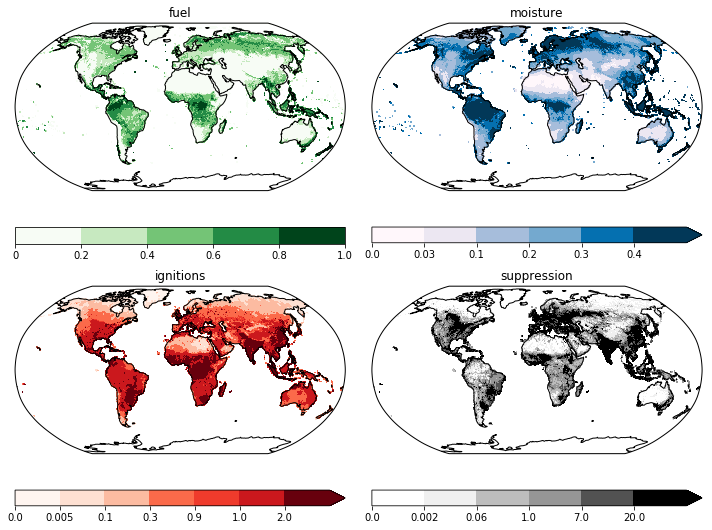

In [324]:
def plotModComponet(comp, n, name = None, levels = None, scale = None, cmap = "brewer_YlOrRd_09", *args, **kws):
    comp = comp.collapsed('z', iris.analysis.MEAN)
    if scale is not None: comp.data = comp.data * scale
    if name  is not None: comp.long_name = name
    plot_lonely_cube(comp, 2, 2, n, levels = levels, cmap = cmap, *args, **kws)

cmap_fuel = 'brewer_Greens_09' 
cmap_moisture = 'brewer_PuBu_09'
cmap_ignitions = 'brewer_Reds_09'
cmap_suppression = 'brewer_Greys_09'
    
plt.figure(figsize = (10, 7.5))   
plotModComponet(model.fuel, 1, 'fuel', [0, 0.2, 0.4, 0.6, 0.8, 1.0], cmap = cmap_fuel)
plotModComponet(model.moisture, 2, 'moisture', cmap = cmap_moisture)
plotModComponet(model.ignitions, 3, 'ignitions', cmap = cmap_ignitions)
plotModComponet(model.suppression, 4, 'suppression', cmap = cmap_suppression)

#### Standard Limitation

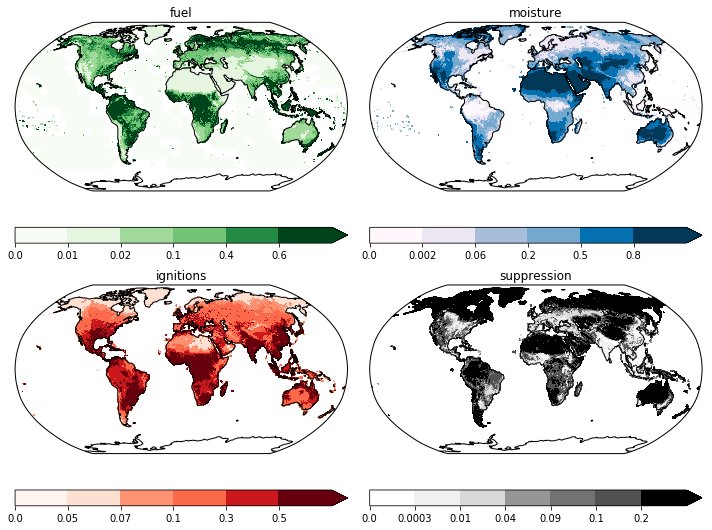

In [320]:
plt.figure(figsize = (10, 7.5))   
plotModComponet(model.standard_fuel, 1, 'fuel', cmap = cmap_fuel)
plotModComponet(model.standard_moisture, 2, 'moisture', cmap = cmap_moisture)
plotModComponet(model.standard_ignitions, 3, 'ignitions', cmap = cmap_ignitions)
plotModComponet(model.standard_suppression, 4, 'suppression', cmap = cmap_suppression)

#### Potential limitation

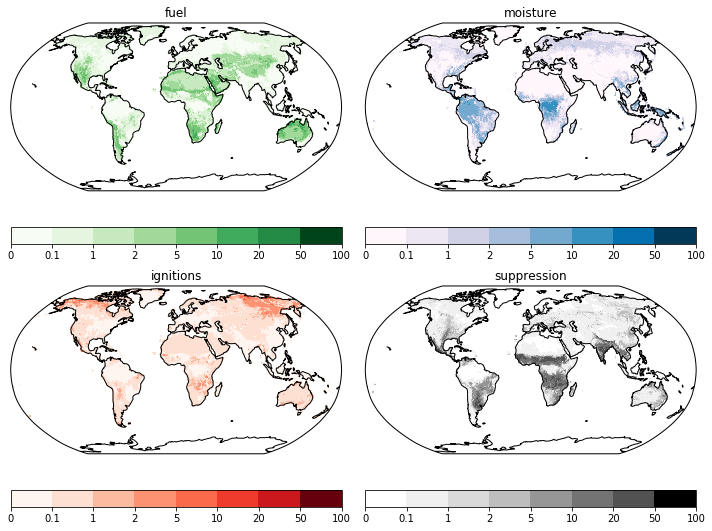

In [321]:
plt.figure(figsize = (10, 7.5))  
levels = [0, 0.1, 1, 2, 5, 10, 20, 50, 100]
plotModComponet(model.potential_fuel(), 1, 'fuel', levels = levels, scale = 100,
                cmap = cmap_fuel)
plotModComponet(model.potential_moisture(), 2, 'moisture', levels = levels, scale = 100,
                cmap = cmap_moisture)
plotModComponet(model.potential_ignitions(), 3, 'ignitions', levels = levels, scale = 100,
                cmap = cmap_ignitions)
plotModComponet(model.potential_suppression(), 4, 'suppression', levels = levels, scale = 100,
                cmap = cmap_suppression)

#### Sensitivty

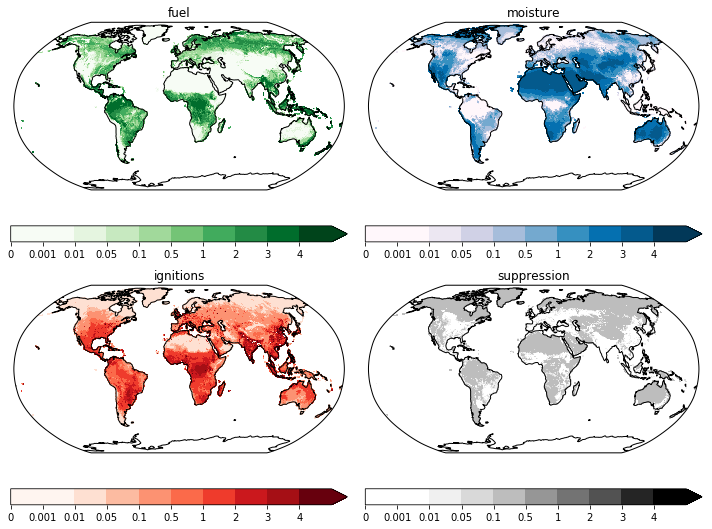

In [328]:
plt.figure(figsize = (10, 7.5))  
levels = [0, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4]
plotModComponet(model.sensitivity_fuel(), 1, 'fuel', levels = levels, 
                cmap = cmap_fuel, extend = 'max')
plotModComponet(model.sensitivity_moisture(), 2, 'moisture', levels = levels, 
                cmap = cmap_moisture, extend = 'max')
plotModComponet(model.sensitivity_ignitions(), 3, 'ignitions', levels = levels, 
                cmap = cmap_ignitions, extend = 'max')
plotModComponet(model.sensitivity_suppression(), 4, 'suppression', levels = levels, 
                cmap = cmap_suppression, extend = 'max')